In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from scipy.stats import f_oneway, kendalltau, chi2_contingency
from sklearn.multiclass import OneVsRestClassifier
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier as XGBoost
from catboost import CatBoostClassifier as CatBoost
from lightgbm import LGBMClassifier as LightGBM

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import shap
from lime.lime_tabular import LimeTabularExplainer

In [2]:
df = pd.read_csv('models_testing.csv')

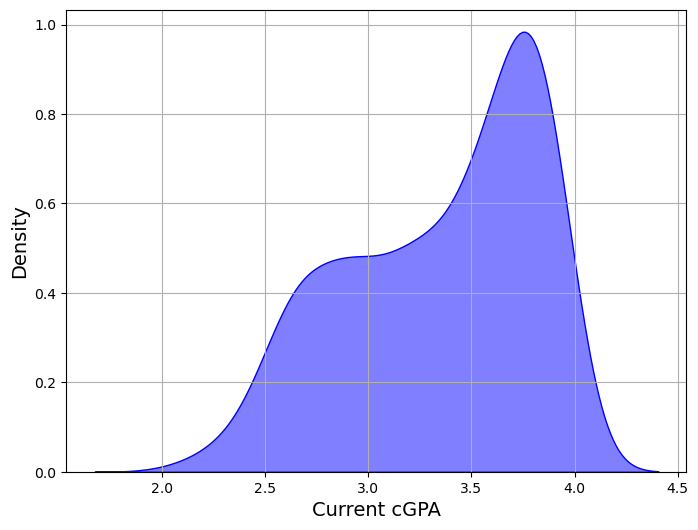

In [3]:
# Plot the density distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(df['curr_cGPA'], fill=True, color='blue', alpha=0.5)
plt.xlabel('Current cGPA', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True)
#plt.savefig("cGPADenDist_Cleaned.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             468 non-null    int64  
 1   uni_adm_yr                             468 non-null    int64  
 2   age                                    468 non-null    int64  
 3   hsc_pass_yr                            468 non-null    int64  
 4   curr_semester                          468 non-null    int64  
 5   study_hrs_day                          468 non-null    int64  
 6   study_seat_day                         468 non-null    int64  
 7   socialmed_hrs_day                      468 non-null    int64  
 8   eng_proficiency                        468 non-null    int64  
 9   avg_class_attend_perc                  468 non-null    int64  
 10  skills                                 468 non-null    object 
 11  skills

In [5]:
df = df.drop(df.columns[[0,10]], axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   uni_adm_yr                             468 non-null    int64  
 1   age                                    468 non-null    int64  
 2   hsc_pass_yr                            468 non-null    int64  
 3   curr_semester                          468 non-null    int64  
 4   study_hrs_day                          468 non-null    int64  
 5   study_seat_day                         468 non-null    int64  
 6   socialmed_hrs_day                      468 non-null    int64  
 7   eng_proficiency                        468 non-null    int64  
 8   avg_class_attend_perc                  468 non-null    int64  
 9   skills_hrs_day                         468 non-null    int64  
 10  previous_sGPA                          468 non-null    float64
 11  curr_c

In [7]:
def classify_binary(cgpa):
    if cgpa < 2.5:
        return 0  # At Risk
    else:
        return 1  # Excellent Standing

df["curr_cGPA_binary"] = df["curr_cGPA"].apply(classify_binary)

print(df["curr_cGPA_binary"].value_counts())

curr_cGPA_binary
1    454
0     14
Name: count, dtype: int64


In [8]:
def classify_ternary(cgpa):
    if cgpa >= 3.5:
        return 2  # Excellent Standing
    elif cgpa >= 2.5 and cgpa < 3.5:
        return 1  # Good Standing
    else:
        return 0  # At Risk

df["curr_cGPA_ternary"] = df["curr_cGPA"].apply(classify_ternary)

print(df["curr_cGPA_ternary"].value_counts())

curr_cGPA_ternary
2    227
1    227
0     14
Name: count, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   uni_adm_yr                             468 non-null    int64  
 1   age                                    468 non-null    int64  
 2   hsc_pass_yr                            468 non-null    int64  
 3   curr_semester                          468 non-null    int64  
 4   study_hrs_day                          468 non-null    int64  
 5   study_seat_day                         468 non-null    int64  
 6   socialmed_hrs_day                      468 non-null    int64  
 7   eng_proficiency                        468 non-null    int64  
 8   avg_class_attend_perc                  468 non-null    int64  
 9   skills_hrs_day                         468 non-null    int64  
 10  previous_sGPA                          468 non-null    float64
 11  curr_c

In [10]:
df[['skills_Other']].value_counts()

skills_Other
0               444
1                24
Name: count, dtype: int64

In [11]:
scaler = MinMaxScaler()

In [12]:
df.uni_adm_yr = scaler.fit_transform(df[['uni_adm_yr']])
df.age = scaler.fit_transform(df[['age']])
df.hsc_pass_yr = scaler.fit_transform(df[['hsc_pass_yr']])

In [13]:
# Mutual Information for categorical variables (Binary)

Xb = df.drop(columns=['curr_cGPA_binary', 
                      'curr_cGPA_ternary', 
                      'credits_completed', 
                      'uni_adm_yr', 
                      'age', 
                      'hsc_pass_yr', 
                      'previous_sGPA', 
                      'fam_income_month'])

yb = df['curr_cGPA_binary']

# Compute Mutual Information (Information Gain)
mi_scores_b = mutual_info_classif(Xb, yb, discrete_features='auto', random_state=42)

# Convert to DataFrame
mi_df_b = pd.DataFrame({'Feature': Xb.columns, 'Mutual_Information': mi_scores_b})
mi_df_b = mi_df_b.sort_values(by='Mutual_Information', ascending=False)

# Display feature importance
print(mi_df_b)

                                  Feature  Mutual_Information
7                               curr_cGPA            0.135526
21                    probation_record_No            0.024867
22                   probation_record_Yes            0.015693
40                              skills_AI            0.013192
16                 pref_learn_mode_Online            0.013186
9                           gender_Female            0.012567
48                skills_WebDev(Frontend)            0.009729
4                         eng_proficiency            0.007443
43                      skills_Networking            0.006870
45                     skills_Programming            0.006768
15                pref_learn_mode_Offline            0.005881
36  relationship_status_In_a_relationship            0.005723
26                    teacher_consult_Yes            0.005642
2                          study_seat_day            0.005622
23                   suspension_record_No            0.005616
17      

In [14]:
# Mutual Information for categorical variables (Ternary)

Xt = df.drop(columns=['curr_cGPA_binary', 
                      'curr_cGPA_ternary', 
                      'credits_completed', 
                      'uni_adm_yr', 
                      'age', 
                      'hsc_pass_yr', 
                      'previous_sGPA', 
                      'fam_income_month'])

yt = df['curr_cGPA_ternary']

# Compute Mutual Information (Information Gain)
mi_scores_t = mutual_info_classif(Xt, yt, discrete_features='auto', random_state=42)

# Convert to DataFrame
mi_df_t = pd.DataFrame({'Feature': Xt.columns, 'Mutual_Information': mi_scores_t})
mi_df_t = mi_df_t.sort_values(by='Mutual_Information', ascending=False)

# Display feature importance
print(mi_df_t)

                                  Feature  Mutual_Information
7                               curr_cGPA            0.809008
27              co_curricular_activity_No            0.053685
11                         scholarship_No            0.047469
30                       co_living_Family            0.045435
21                    probation_record_No            0.037604
20                      personal_comp_Yes            0.033043
10                            gender_Male            0.022452
16                 pref_learn_mode_Online            0.021891
28             co_curricular_activity_Yes            0.020640
12                        scholarship_Yes            0.017400
43                      skills_Networking            0.017066
6                          skills_hrs_day            0.014933
29                     co_living_Bachelor            0.014450
3                       socialmed_hrs_day            0.014369
33                 physical_disability_No            0.012828
8       

In [15]:
# Chi-Squared Test for categorical features (Binary)

to_drop_b = []
for i in Xb.columns:
    cont_table = pd.crosstab(Xb[i], yb)
    chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
    if p_value <= 0.05:
        print(f'{i}\'s p-value is {p_value}')
        print('')
    else:
        to_drop_b.append(i)

study_seat_day's p-value is 1.055159375380247e-06

socialmed_hrs_day's p-value is 0.04361592419721044

curr_cGPA's p-value is 3.89514069307632e-34

probation_record_No's p-value is 2.401474728378453e-06

probation_record_Yes's p-value is 2.401474728378453e-06

relationship_status_Married's p-value is 0.025376714963808587



In [16]:
# Chi-Squared Test for categorical features (Ternary)

to_drop_t = []
for i in Xt.columns:
    cont_table = pd.crosstab(Xt[i], yt)
    chi2_stat, p_value, dof, expected = chi2_contingency(cont_table)
    if p_value <= 0.05:
        print(f'{i}\'s p-value is {p_value}')
        print('')
    else:
        to_drop_t.append(i)

study_seat_day's p-value is 4.568013668803535e-05

socialmed_hrs_day's p-value is 0.0013253427851189971

curr_cGPA's p-value is 4.981359493433854e-66

scholarship_No's p-value is 0.0002409445235824976

scholarship_Yes's p-value is 0.00024094452358249807

probation_record_No's p-value is 6.182309378842737e-07

probation_record_Yes's p-value is 6.182309378842737e-07

suspension_record_No's p-value is 0.04923605274591826

suspension_record_Yes's p-value is 0.04923605274591826

co_curricular_activity_No's p-value is 0.0464096344894283

co_curricular_activity_Yes's p-value is 0.046409634489428336

co_living_Bachelor's p-value is 0.0179754622230377

co_living_Family's p-value is 0.017975462223037676

relationship_status_Engaged's p-value is 0.008317827053754811

relationship_status_Married's p-value is 0.02468265565914689

curr_acad_yr's p-value is 0.03754461706841629



In [17]:
# ANOVA numerical features correlation test (Binary)

numerical_features = df[['uni_adm_yr', 'age', 'hsc_pass_yr', 'previous_sGPA', 'credits_completed', 'fam_income_month']]

num_drop_b = []
print('ANOVA correlation test for Binary:')
for i in numerical_features:
    category = df.groupby('curr_cGPA_binary')[i].apply(list)
    anova_results = f_oneway(*category)
    print('')
    print(f'{i} p-value is: {anova_results[1]}')
    if anova_results[1] > 0.05:
        num_drop_b.append(i) 

ANOVA correlation test for Binary:

uni_adm_yr p-value is: 0.9718155227315972

age p-value is: 0.6894193792476788

hsc_pass_yr p-value is: 0.8580672023320832

previous_sGPA p-value is: 0.00028006439139078876

credits_completed p-value is: 0.15212017037339617

fam_income_month p-value is: 0.12124653514292495


In [18]:
# Kendall's correlation numerical features (Binary)

print('Kendall\'s correlation for Binary:')
for i in numerical_features:
    tau_b, pvalue = kendalltau(df[i], df['curr_cGPA_binary'])
    print('')
    print(f'{i} correlation is: {tau_b}')

Kendall's correlation for Binary:

uni_adm_yr correlation is: -0.00640991236852028

age correlation is: -0.014702483125986415

hsc_pass_yr correlation is: 0.012589901870782917

previous_sGPA correlation is: 0.132570415537086

credits_completed correlation is: 0.05094924567064246

fam_income_month correlation is: 0.05370737888056933


In [19]:
# ANOVA numerical features correlation test (Ternary)

num_drop_t = []
print('ANOVA correlation test for Ternary:')
for i in numerical_features:
    category = df.groupby('curr_cGPA_ternary')[i].apply(list)
    anova_results = f_oneway(*category)
    print('')
    print(f'{i} p-value is: {anova_results[1]}')
    if anova_results[1] > 0.05:
        num_drop_t.append(i)

ANOVA correlation test for Ternary:

uni_adm_yr p-value is: 0.6344719214579961

age p-value is: 0.7547983906377465

hsc_pass_yr p-value is: 0.9841530978372185

previous_sGPA p-value is: 2.1300731556052443e-29

credits_completed p-value is: 0.18811776306324476

fam_income_month p-value is: 0.13233760095960298


In [20]:
# Kendall's correlation numerical features (Ternary)

print('Kendall\'s correlation for Ternary:')
for i in numerical_features:
    tau_b, pvalue = kendalltau(df[i], df['curr_cGPA_ternary'])
    print('')
    print(f'{i} correlation is: {tau_b}')

Kendall's correlation for Ternary:

uni_adm_yr correlation is: 0.02821717265932836

age correlation is: -0.025925542455643123

hsc_pass_yr correlation is: -0.0033619504192580153

previous_sGPA correlation is: 0.3835090728197929

credits_completed correlation is: 0.05857483528127064

fam_income_month correlation is: 0.06851075441849107


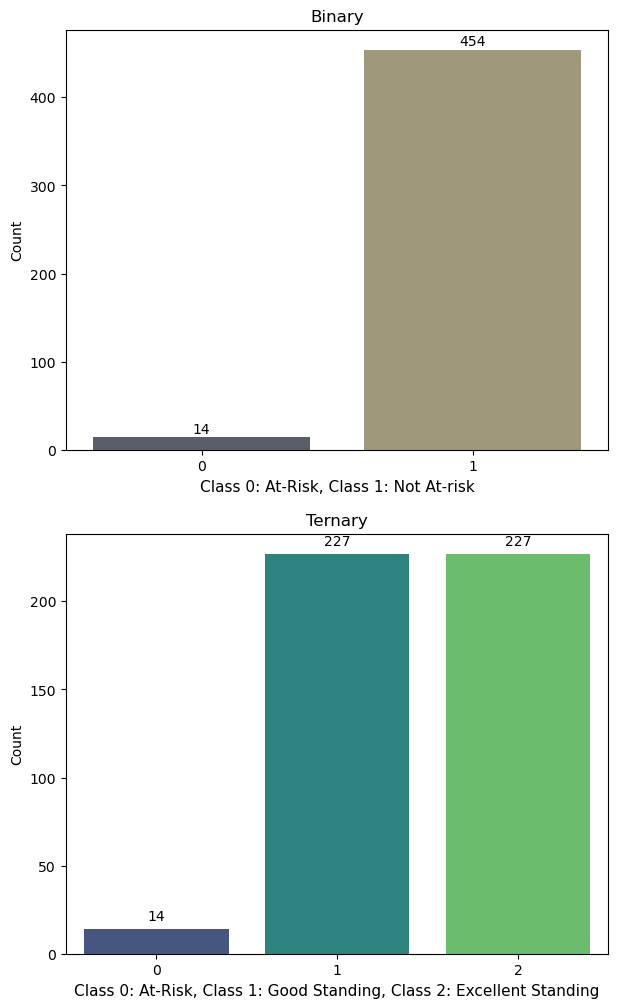

In [21]:
plt.figure(figsize=(7, 12))

plt.subplot(2, 1, 1)
sns.countplot(x=df["curr_cGPA_binary"], palette="cividis")
plt.title("Binary", fontsize=12)
plt.xlabel("Class 0: At-Risk, Class 1: Not At-risk", fontsize=11)
plt.ylabel("Count")
for i in range(df["curr_cGPA_binary"].nunique()):
    count = df["curr_cGPA_binary"].value_counts()[i]
    plt.text(i, count + 5, str(count), ha="center")

plt.subplot(2, 1, 2)
sns.countplot(x=df["curr_cGPA_ternary"], palette="viridis")
plt.title("Ternary", fontsize=12)
plt.xlabel("Class 0: At-Risk, Class 1: Good Standing, Class 2: Excellent Standing", fontsize=11)
plt.ylabel("Count")
for i in range(df["curr_cGPA_ternary"].nunique()):
    count = df["curr_cGPA_ternary"].value_counts()[i]
    plt.text(i, count + 5, str(count), ha="center")
#plt.savefig("cGPA_Class_Bins.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [22]:
random_seed = 64

In [23]:
dt_model = DecisionTreeClassifier(random_state=random_seed)
rf_model = RandomForestClassifier(random_state=random_seed)
svm_model = SVC(probability=True, random_state=random_seed)

gb_model = GradientBoostingClassifier(random_state=random_seed)
xgb_model = XGBoost(random_state=random_seed)
cb_model = CatBoost(silent = True, random_state=random_seed)
lgbm_model = LightGBM(random_state=random_seed, verbose = -1)

In [24]:
dt_param_grid_b = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [1,2,3,4,5],
                   'model__min_samples_split': [2, 3, 4, 5, 6],
                   'model__min_samples_leaf': [2, 3, 4, 5, 10],
                   'model__min_weight_fraction_leaf': [0.1,0.2,0.3]
}

In [25]:
rf_param_grid_b = {'model__max_depth': [1,2,3,4,5],
                   'model__n_estimators': [1,2,3,4,5,6,7,8], 
                   'model__criterion': ['gini','entropy']
}

In [26]:
svm_param_grid_b = {'model__kernel': ['linear'],
                    'model__C': [3, 4, 5, 6, 7, 8, 9, 10]               
}

In [27]:
gb_param_grid_b = {'model__max_depth': [1,2,3,4],
                   'model__n_estimators': [10, 15, 20, 50, 100, 150]}

In [28]:
xgb_param_grid_b = {'model__max_depth': [1],
                    'model__n_estimators': [300],
                    'model__learning_rate': [1],
                    'model__lambda': [5,10,15,20,30]
}

In [29]:
cb_param_grid_b = {'model__max_depth': [1,2],
                   'model__n_estimators': [10,15,30,40,50,100,150,200],
                   'model__learning_rate': np.arange(0.1, 0.7, 0.1)
}

In [30]:
lgbm_param_grid_b = {'model__max_depth': [1,2],
                     'model__num_iterations': [10,50,100,150],
                     'model__num_leaves': [5,10,20,30]
}

In [31]:
dt_param_grid_t = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [1,5,10,15],
                   'model__min_samples_split': [15,20,30,40],
                   'model__min_samples_leaf': [1,2]
}

In [32]:
rf_param_grid_t = {'model__criterion': ['gini','entropy'],
                   'model__max_depth': [1,5,10,15,20,30,40,50],
                   'model__n_estimators': [1,2,3,4,5,10,20,30,40,50,60,70,80]
}

In [33]:
svm_param_grid_t = {'model__kernel': ['rbf', 'linear'],
                    'model__C': [40,50,60,70,80]
}

In [34]:
gb_param_grid_t = {'model__max_depth': [1,2,3,4],
                   'model__n_estimators': [1,2,3,4,5,10,20,30,40,50,60,70],
                   'model__max_leaf_nodes': [2,3,4,5,10,15,20,30],
                   'model__min_samples_split': [2,3,4,5]
}

In [35]:
xgb_param_grid_t = {'model__max_depth': [1,2,3,4],
                    'model__n_estimators': [1,2,3,4,5,10,15,20,30,40,50,60]
}

In [36]:
cb_param_grid_t = {'model__max_depth': [1,2,3],
                   'model__n_estimators': [1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,150,200,250],
                   'model__grow_policy': ['Lossguide'],
                   'model__max_leaves': [2,3,4],
                   'model__min_child_samples': [1,2,3,4,5]
}

In [37]:
lgbm_param_grid_t = {'model__max_depth': [1,2,3],
                     'model__num_iterations': [100,110,120,150]
}

Best params: {'model__n_estimators': 40, 'model__max_depth': 3}

              precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       0.88      0.81      0.84        69
           2       0.88      0.85      0.87        68

    accuracy                           0.84       141
   macro avg       0.71      0.89      0.75       141
weighted avg       0.86      0.84      0.84       141



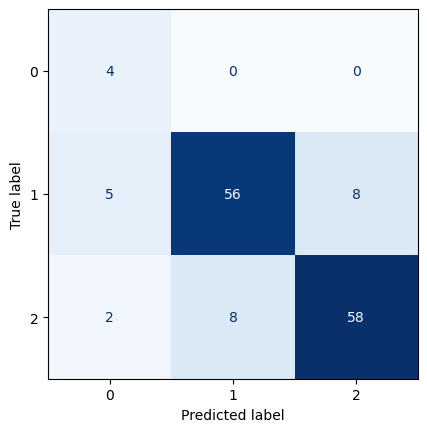

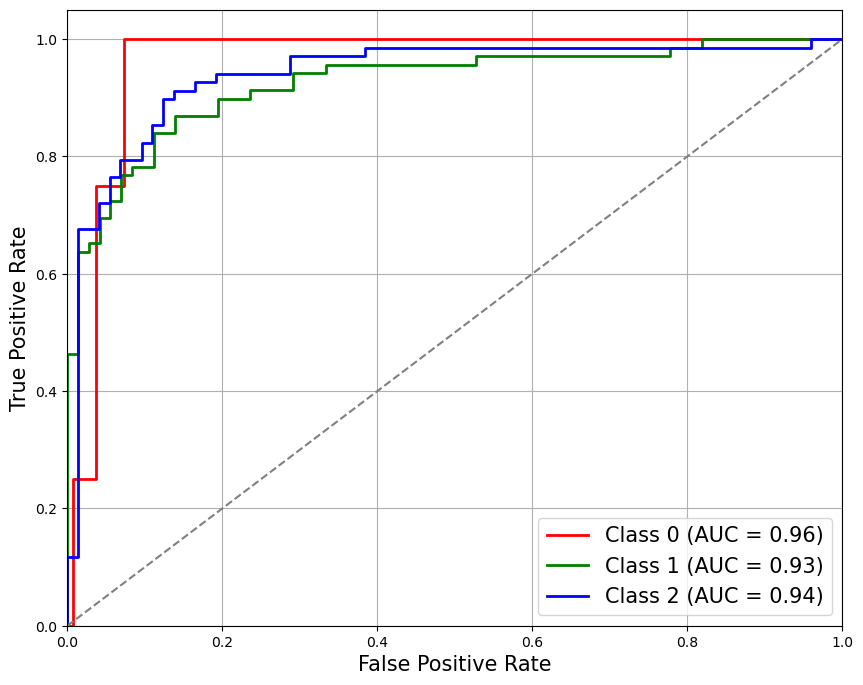

'\nfpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)\nroc_auc = roc_auc_score(y_test == 0, y_prob)\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, color=\'red\', lw=2, label=f\'Class 0 (AUC = {roc_auc:.2f}))\')\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\', fontsize=15)\nplt.ylabel(\'True Positive Rate\', fontsize=15)\nplt.legend(loc="lower right", prop={\'size\': 15})\nplt.grid(True)\n#plt.savefig("LGBM_AUC-ROC_B.pdf", format="pdf", bbox_inches="tight")\nplt.show()'

In [38]:
"""
X = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA'], axis = 1)
cX = X.drop(columns = to_drop_b, axis = 1)
nX =  cX.drop(columns = num_drop_b, axis = 1)

fX = nX.drop(columns=['probation_record_No'], axis = 1)

y = df['curr_cGPA_binary']

"""
X_2 = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA'])
cX_2 = X_2.drop(columns = to_drop_t, axis = 1)
nX_2 = cX_2.drop(columns = num_drop_t, axis = 1)

fX_2 = nX_2.drop(columns=['suspension_record_No','probation_record_No','scholarship_Yes','co_living_Bachelor', 'co_curricular_activity_Yes'], axis = 1)

y_2 = df['curr_cGPA_ternary']

X_train, X_test, y_train, y_test = train_test_split(fX_2, y_2, test_size=0.3, stratify=y_2, random_state=random_seed)


# 1) Define pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=random_seed)),
    ('model', xgb_model)
])

# 3) CV splitter (only training data!)
scv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

# 4) Grid search on X_train, y_train
search = RandomizedSearchCV(pipeline, param_distributions=xgb_param_grid_t, cv=scv, scoring='recall_weighted', n_jobs=-1, random_state=random_seed)

search.fit(X_train, y_train)  
print("Best params:", search.best_params_)

# Retrain best‐found pipeline on the full training set:
best_model = search.best_estimator_

# Predict on your untouched hold‐out:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 0]

print()
print(classification_report(y_test, y_pred))

# 1) Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.named_steps['model'].classes_)

# 2) Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['model'].classes_)
disp.plot(cmap='Blues', colorbar=False)
plt.show()


# Step 1: Binarize y_test for multiclass ROC
y_test_bin = label_binarize(y_test, classes=best_model.named_steps['model'].classes_)

# Step 2: Get predicted probabilities (shape: [n_samples, n_classes])
y_score = best_model.predict_proba(X_test)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc="lower right", prop={'size': 15})
plt.grid(True)
#plt.savefig("LGBM_AUC-ROC_T.pdf", format="pdf", bbox_inches="tight")
plt.show()

"""
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = roc_auc_score(y_test == 0, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Class 0 (AUC = {roc_auc:.2f}))')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc="lower right", prop={'size': 15})
plt.grid(True)
#plt.savefig("LGBM_AUC-ROC_B.pdf", format="pdf", bbox_inches="tight")
plt.show()"""

In [39]:
faa

NameError: name 'faa' is not defined

In [40]:
print(np.where(y_test.values == 0))

(array([ 0, 73, 77, 98], dtype=int64),)


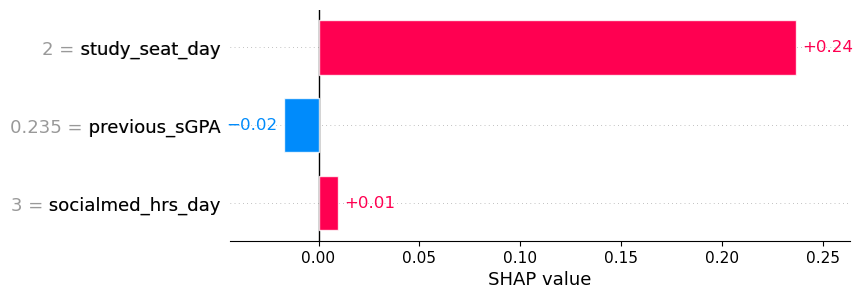

'\nidx = 0\nX_inst = X_test.iloc[[idx]]\n\n# 4) Compute SHAP values for that instance\n#    returns an array of shape (n_classes, n_features) for multiclass\n#shap_values = explainer.shap_values(X_inst)\n\npred_class = best_model.predict(X_inst)\n\nshap_values = explainer.shap_values(X_inst)\n\n\nshap.plots.bar(\n    shap.Explanation(shap_values[0],data=X_inst.iloc[0], feature_names=X_test.columns.tolist()\n))\n\nshap.plots.bar(\n    shap.Explanation(\n        values=shap_values[0],\n        base_values=explainer.expected_value[pred_class],\n        data=X_inst.iloc[0],\n        feature_names=X_test.columns.tolist()\n    ),\n    max_display=11\n)'

In [67]:
# 1) Extract the raw XGBClassifier from your pipeline
clf = best_model.named_steps['model']

# 2) Create the TreeExplainer
explainer = shap.TreeExplainer(clf, data=X_train)


# 3) Select instance
idx = 98
X_inst = X_test.iloc[[idx]]
pred_class = best_model.predict(X_inst)[0]

# 4) Get SHAP values for the selected instance
shap_values = explainer.shap_values(X_inst)

# 5) Create a full Explanation object with all features
exp = shap.Explanation(
    values=shap_values[pred_class][0],
    base_values=explainer.expected_value[pred_class],
    data=X_inst.iloc[0],
    feature_names=X_test.columns.tolist()
)

# 6) Plot all features using SHAP's bar plot
shap.plots.bar(exp, max_display=len(X_test.columns))
# 3) Choose the test instance you want to explain
"""
idx = 0
X_inst = X_test.iloc[[idx]]

# 4) Compute SHAP values for that instance
#    returns an array of shape (n_classes, n_features) for multiclass
#shap_values = explainer.shap_values(X_inst)

pred_class = best_model.predict(X_inst)

shap_values = explainer.shap_values(X_inst)


shap.plots.bar(
    shap.Explanation(shap_values[0],data=X_inst.iloc[0], feature_names=X_test.columns.tolist()
))

shap.plots.bar(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value[pred_class],
        data=X_inst.iloc[0],
        feature_names=X_test.columns.tolist()
    ),
    max_display=11
)"""

In [64]:
# 0) Extract raw NumPy arrays
X_train_arr = X_train.values
X_test_arr  = X_test.values
feature_names = X_train.columns.tolist()
class_names   = [str(c) for c in best_model.named_steps['model'].classes_]

# 1) Create the LIME explainer
explainer = LimeTabularExplainer(
    X_train_arr,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=False,
    random_state=random_seed
)

# 2) Choose instance index to explain
idx = 73
x_instance = X_test_arr[idx]

# 3) Generate explanation
#    - predict_proba must return shape (n_samples, n_classes)
exp = explainer.explain_instance(
    x_instance,
    best_model.predict_proba,
    num_features=11, top_labels= 1)


# 4) Print out the top contributing features for each class
for label in exp.available_labels():
    print(f"\nClass = {class_names[label]}  (explanation for label {label}):\n")
    for feat, weight in exp.as_list(label=label):
        print(f"  {feat:30s}  {weight:+0.4f}")

exp.show_in_notebook(show_table=True)

#exp.save_to_file('CB_LIME_B.html')


Class = 0  (explanation for label 0):

  previous_sGPA                   -0.1322
  co_curricular_activity_No       -0.0969
  socialmed_hrs_day               +0.0810
  curr_acad_yr                    -0.0749
  study_seat_day                  +0.0668
  co_living_Family                -0.0197
  scholarship_No                  -0.0148
  probation_record_Yes            +0.0135
  relationship_status_Engaged     -0.0033
  relationship_status_Married     -0.0020
  suspension_record_Yes           +0.0004


In [ ]:
jhh

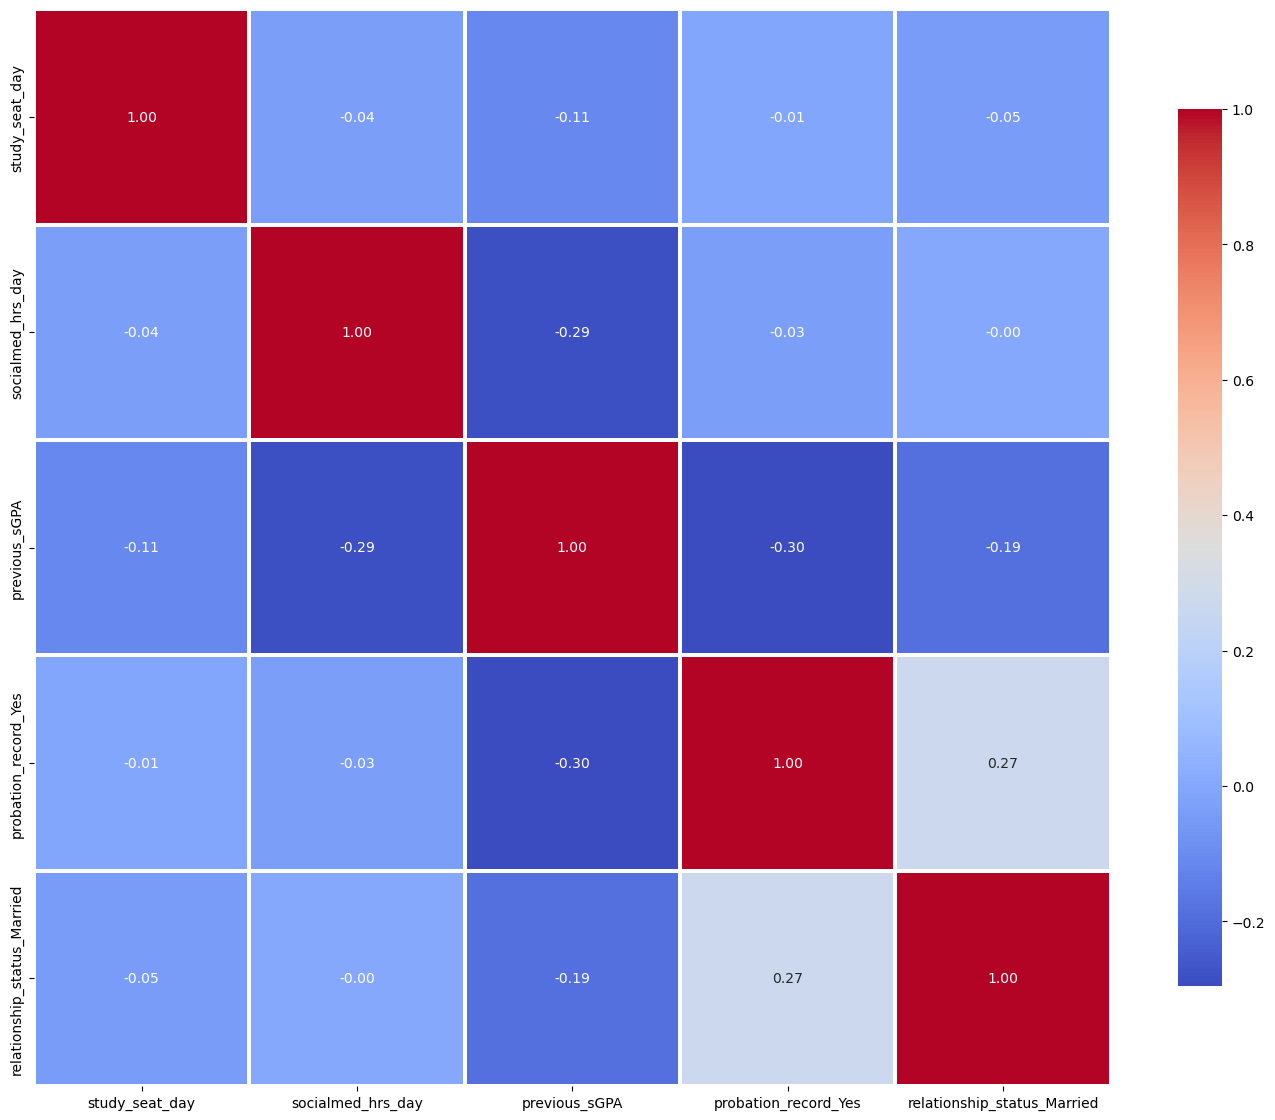

In [ ]:
# Plotting the correlation heatmap
X = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA'], axis = 1)
cX = X.drop(columns = to_drop_b, axis = 1)
nX =  cX.drop(columns = num_drop_b, axis = 1)

fX = nX.drop(columns=['probation_record_No'], axis = 1)

y = df['curr_cGPA_binary']

plt.figure(figsize=(14, 12))
sns.heatmap(fX.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1.5, cbar_kws={"shrink": 0.75})

plt.tight_layout()
plt.savefig("B_Final_Corr_HM.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(327, 5)
(141, 5)


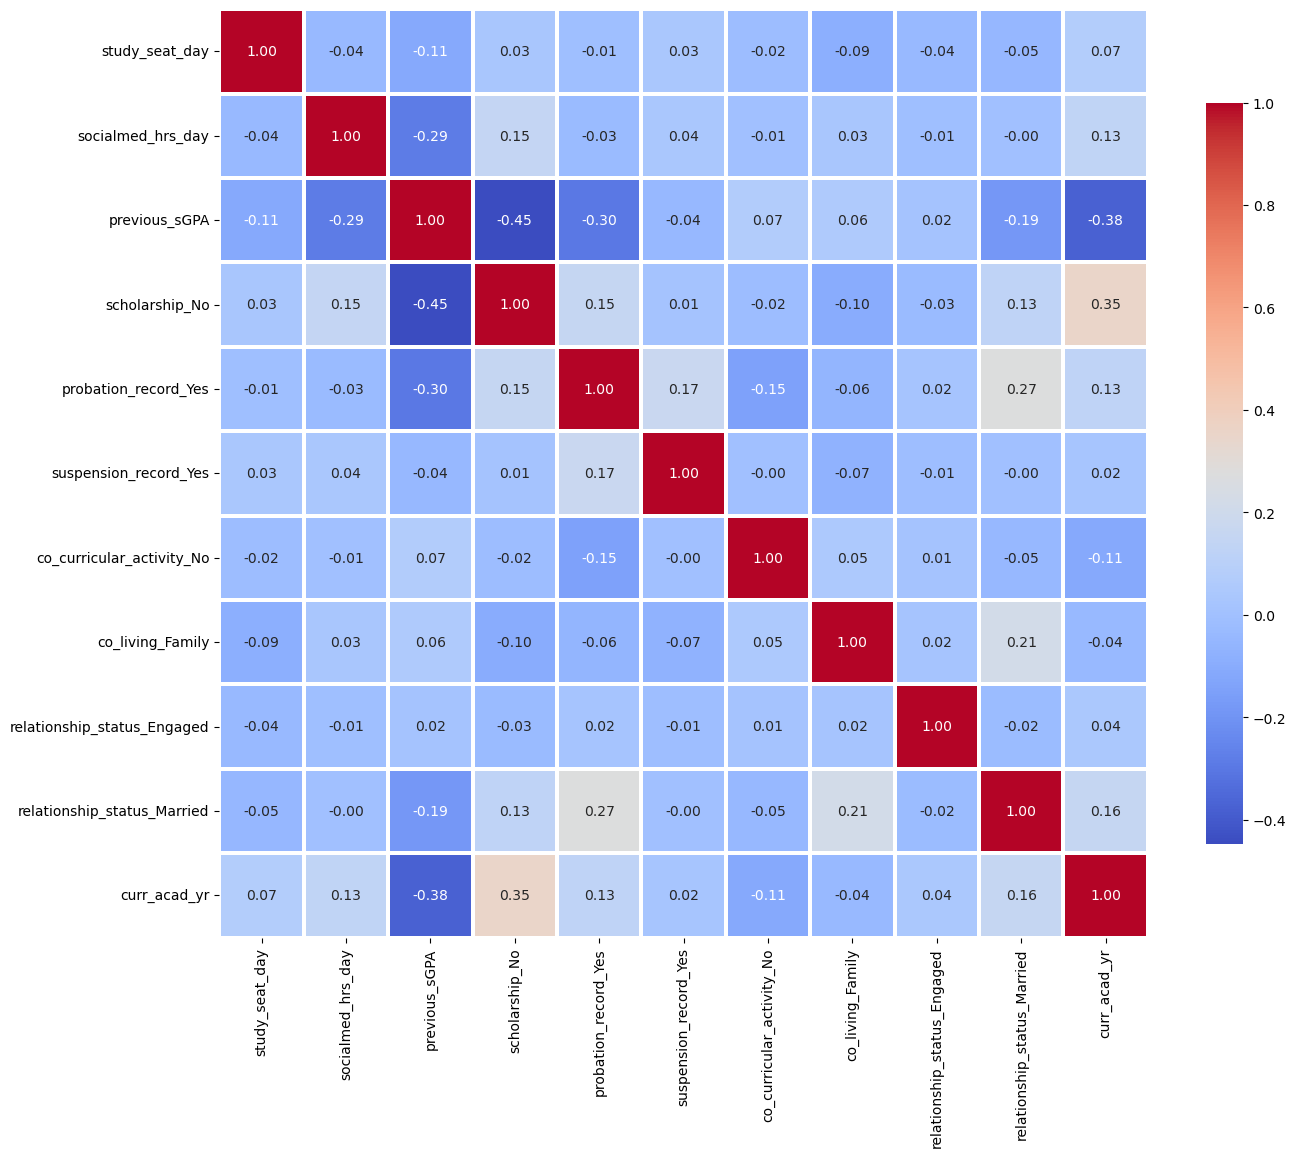

In [ ]:
X_2 = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA'])
cX_2 = X_2.drop(columns = to_drop_t, axis = 1)
nX_2 = cX_2.drop(columns = num_drop_t, axis = 1)

fX_2 = nX_2.drop(columns=['suspension_record_No','probation_record_No','scholarship_Yes','co_living_Bachelor', 'co_curricular_activity_Yes'], axis = 1)

y_2 = df['curr_cGPA_ternary']

# Plotting the correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(fX_2.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1.5, cbar_kws={"shrink": 0.75})

plt.tight_layout()
plt.savefig("T_Final_Corr_HM.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
"""# SHAP values for interpretability
explainer = shap.Explainer(best_model.named_steps['model'], X_train)
shap_values = explainer(X_test)

shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0], 
                                      base_values=explainer.expected_value[1], 
                                      data=X_test.iloc[0], 
                                      feature_names=X_test.columns))"""

(94, 5, 2)

              precision    recall  f1-score   support

           0       0.19      0.29      0.23        14
           1       0.98      0.96      0.97       454

    accuracy                           0.94       468
   macro avg       0.58      0.62      0.60       468
weighted avg       0.95      0.94      0.95       468



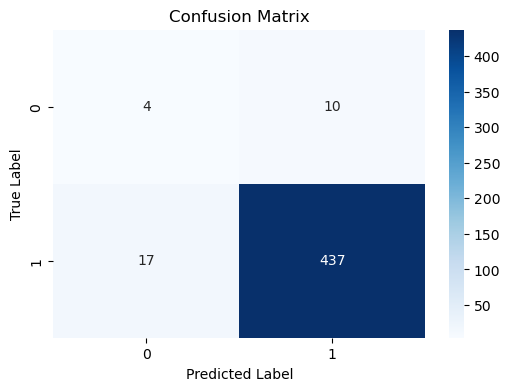

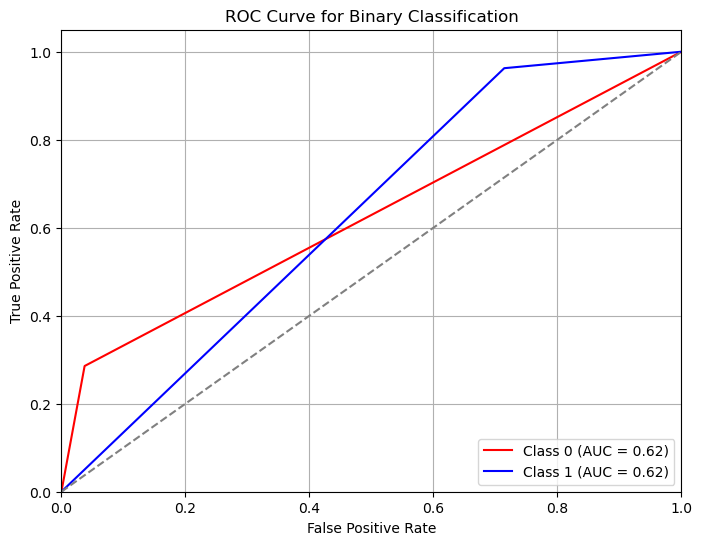

In [ ]:
# Models Testing (Binary)

X = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA_quaternary'], axis = 1)
cX = X.drop(columns = to_drop_b, axis = 1)
nX =  cX.drop(columns = num_drop_b, axis = 1)

fX = nX.drop(columns=['probation_record_No'], axis = 1)

y = df['curr_cGPA_binary'] 

# Store best hyperparameters from each fold
best_params_list_b = {}

# Store actual and predicted labels
y_true_all_b, y_pred_all_b = [], []
y_prob_all_b = []

#minority_scorer_b = make_scorer(recall_score, average='binary', pos_label=0)

print(f'Classification Hyper parameter tuning')

y_true_all_b, y_pred_all_b = [], [] 

# Perform stratified cross-validation within each fold + SMOTE
for fold, (train_idx, test_idx) in enumerate(skf.split(fX, y), start=1):
    # Split data
    X_train, X_test = fX.iloc[train_idx], fX.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Applying SMOTE only on the training set
    smote = SMOTE(random_state=42)

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Setting up the search
    search = RandomizedSearchCV(dt_model, dt_param_grid_b_1, cv=10, random_state=42, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)
    
    # Getting the best model parameters
    best_params = search.best_estimator_

    # Storing the best parameters for each fold within a dictionary
    best_params_list_b[f"Fold {fold}"] = search.best_params_
    print(f'Best Params for Fold {fold}: {search.best_params_}')

    # Predict on the X test set
    y_pred = best_params.predict(X_test)
    y_prob = best_params.predict_proba(X_test)[:, 1]

    # Store results
    y_true_all_b.extend(y_test)
    y_pred_all_b.extend(y_pred)
    y_prob_all_b.extend(y_prob)
    
# Print final Binary classification report
print(classification_report(y_true_all_b, y_pred_all_b))

# Binary Confusion Matrix
cm = confusion_matrix(y_true_all_b, y_pred_all_b)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels= np.sort(y.unique()), yticklabels=np.sort(y.unique()))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve and AUC for both classes directly
fpr_b = {}
tpr_b = {}
roc_auc_b = {}

# Class 1
fpr_b[1], tpr_b[1], threshold_1 = roc_curve(y_true_all_b, y_prob_all_b, pos_label=1)
roc_auc_b[1] = auc(fpr_b[1], tpr_b[1])

# Class 0
fpr_b[0], tpr_b[0], threshold_0 = roc_curve(y_true_all_b, [1 - p for p in y_prob_all_b], pos_label=0)
roc_auc_b[0] = auc(fpr_b[0], tpr_b[0])

plt.figure(figsize=(8,6))
plt.plot(fpr_b[0], tpr_b[0], label=f"Class 0 (AUC = {roc_auc_b[0]:.2f})", linestyle='-', color='red')
plt.plot(fpr_b[1], tpr_b[1], label=f"Class 1 (AUC = {roc_auc_b[1]:.2f})", linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
sdgs

In [ ]:
X = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA'], axis = 1)
cX = X.drop(columns = to_drop_b, axis = 1)
nX =  cX.drop(columns = num_drop_b, axis = 1)

fX = nX.drop(columns=['probation_record_No'], axis = 1)

y = df['curr_cGPA_binary'] 

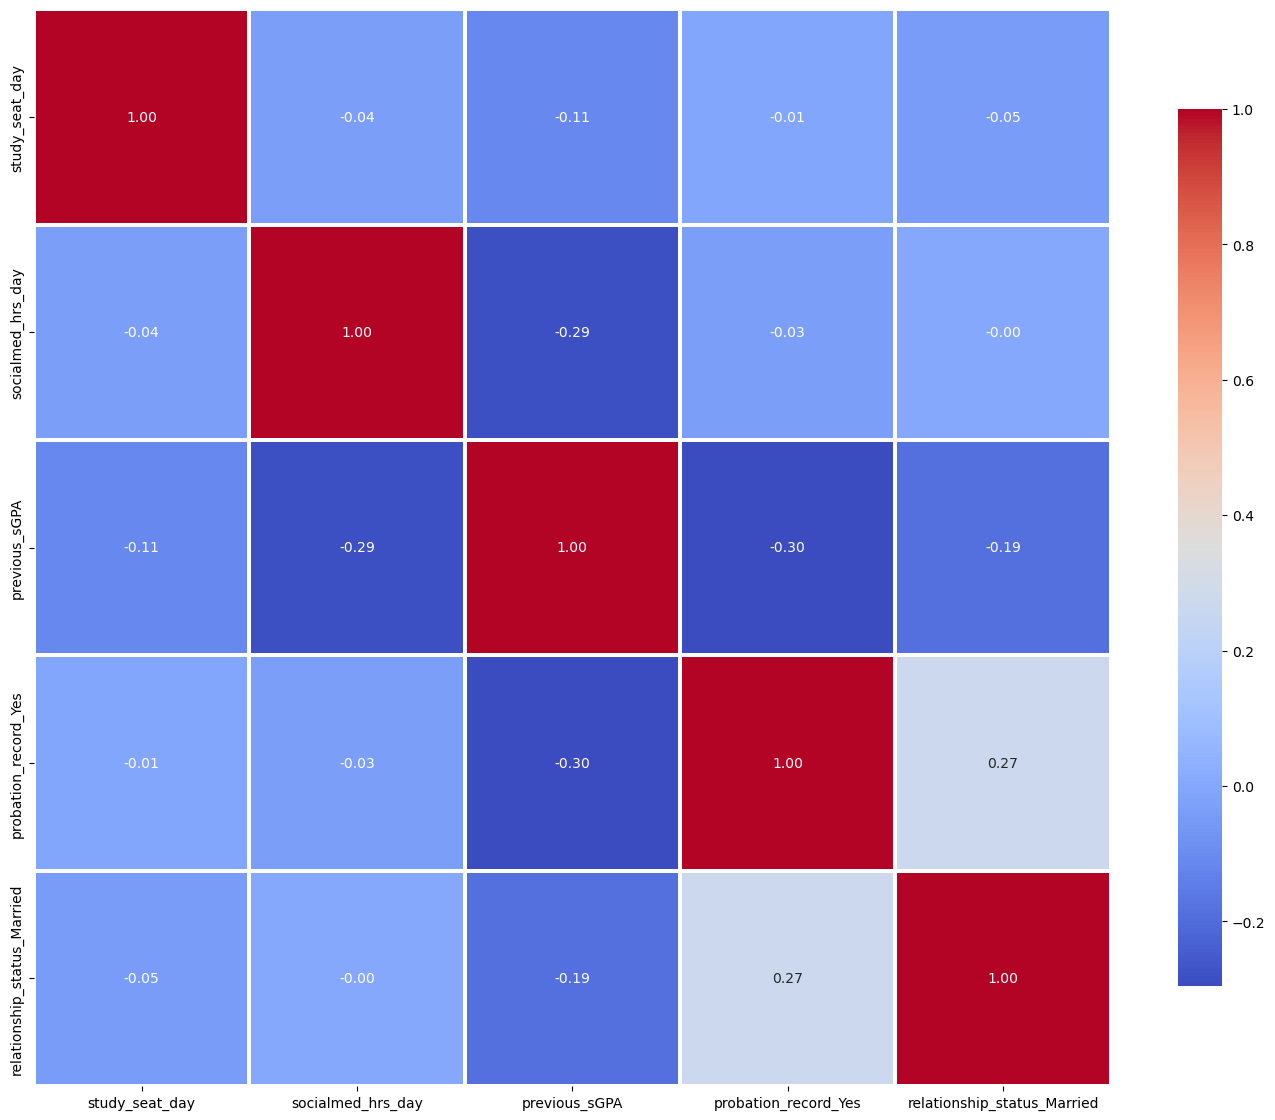

In [ ]:
# Plotting the correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(fX.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=1.5, cbar_kws={"shrink": 0.75})

plt.tight_layout()
plt.show()

Classification Hyper parameter tuning
Best Params for Fold 1: {'n_estimators': 30, 'min_weight_fraction_leaf': 0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.1, 'max_leaf_nodes': 60, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Best Params for Fold 2: {'n_estimators': 30, 'min_weight_fraction_leaf': 0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.1, 'max_leaf_nodes': 60, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Best Params for Fold 3: {'n_estimators': 30, 'min_weight_fraction_leaf': 0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.1, 'max_leaf_nodes': 60, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Best Params for Fold 4: {'n_estimators': 30, 'min_weight_fraction_leaf': 0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.1, 'max_leaf_nodes': 60, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
Best Params for Fold 5: {'n_estimators': 3

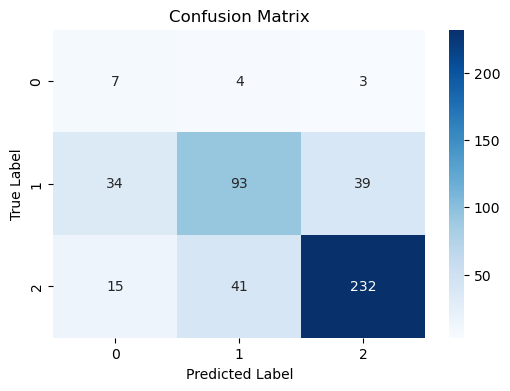

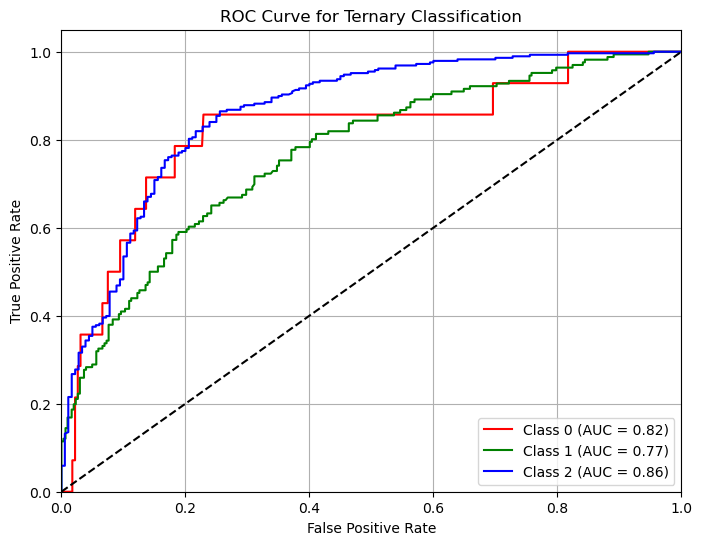

In [ ]:
# Models Testing (Ternary)

X_2 = df.drop(columns=['curr_cGPA_binary', 'curr_cGPA_ternary', 'curr_cGPA_quaternary'])
cX_2 = X_2.drop(columns = to_drop_t, axis = 1)
nX_2 = cX_2.drop(columns = num_drop_t, axis = 1)

fX_2 = nX_2.drop(columns=['suspension_record_No','probation_record_No','scholarship_Yes','co_living_Bachelor'], axis = 1)

y_2 = df['curr_cGPA_ternary'] 

minority_scorer_t = make_scorer(recall_score, average='weighted', pos_label=0)

classes_t = np.sort(y_2.unique())

# Store best hyperparameters from each fold
best_params_list_t = {}

print(f'Classification Hyper parameter tuning')

# Store actual and predicted labels
y_true_all_t, y_pred_all_t = [], []
y_true_bin_all_t, y_prob_all_t = [], []

# Perform stratified cross-validation within each fold
for fold, (train_idx, test_idx) in enumerate(skf.split(fX_2, y_2), start=1):
    # Splitting the data
    X_train, X_test = fX_2.iloc[train_idx], fX_2.iloc[test_idx]
    y_train, y_test = y_2.iloc[train_idx], y_2.iloc[test_idx]

    # Applying SMOTE only on the training set
    smote = SMOTE(random_state=42)

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Setting up Randozied search 
    search = RandomizedSearchCV(rf_model, rf_param_grid_t, cv=10, random_state=42, n_jobs=-1)
    search.fit(X_train_resampled, y_train_resampled)

    # Getting the best model parameters
    best_params = search.best_estimator_

    # Storing the best parameters for each fold within a dictionary
    best_params_list_t[f"Fold {fold}"] = search.best_params_
    print(f'Best Params for Fold {fold}: {search.best_params_}')

    # Predict on X test set
    y_pred = best_params.predict(X_test)
    y_prob = best_params.predict_proba(X_test)

    y_test_bin = label_binarize(y_test, classes=classes_t)

    # Store results
    y_true_all_t.extend(y_test)
    y_pred_all_t.extend(y_pred)
    y_true_bin_all_t.extend(y_test_bin)
    y_prob_all_t.extend(y_prob)

# Print final Ternary classification report
print(classification_report(y_true_all_t, y_pred_all_t))

# -----------------------
# ternary Confusion Matrix
# -----------------------
cm_2 = confusion_matrix(y_true_all_t, y_pred_all_t)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=classes_t, yticklabels=classes_t)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# -----------------------
# Ternary AUC-ROC Plot
# -----------------------
y_true_bin_all_t = np.array(y_true_bin_all_t)
y_prob_all_t = np.array(y_prob_all_t)
n_classes_t = y_true_bin_all_t.shape[1]

fpr_t = dict()
tpr_t = dict()
roc_auc_t = dict()

for i in range(n_classes_t):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_true_bin_all_t[:, i], y_prob_all_t[:, i])
    roc_auc_t[i] = auc(fpr_t[i], tpr_t[i])

# Plotting
plt.figure(figsize=(8, 6))
colors_t = ['red', 'green', 'blue']
for i in range(n_classes_t):
    plt.plot(fpr_t[i], tpr_t[i], color=colors_t[i % len(colors_t)],
             label=f'Class {classes_t[i]} (AUC = {roc_auc_t[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Ternary Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()